# Feature Selection & Model Training Experiment

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore') 

# Sklearn
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Boruta
from boruta import BorutaPy

# Note: Using GradientBoostingClassifier as XGBoost alternative
# (XGBoost requires OpenMP runtime which is not installed)
print("Using GradientBoostingClassifier as XGBoost alternative")
print("✅ Using 5-Fold Stratified Cross Validation")
print("Libraries imported successfully!")

Using GradientBoostingClassifier as XGBoost alternative
✅ Using 5-Fold Stratified Cross Validation
Libraries imported successfully!


## 2. Load Dataset

In [2]:
# Load dataset
df = pd.read_csv('PhiUSIIL_Phishing_URL_63_Features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:\n{df['label'].value_counts()}")

Dataset shape: (235795, 59)

Columns: ['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'num_hyphens', 'URL_Profanity_Prob', 'URL_NumberOf_Profanity', 'URLContent_Profanity_

## 3. Data Preprocessing

In [3]:
# Kolom non-numerik yang harus di-drop
non_numeric_cols = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title'] # bukan fitur numerik

# Drop kolom non-numerik
df_numeric = df.drop(columns=non_numeric_cols, errors='ignore')

# Pisahkan fitur dan target
X = df_numeric.drop(columns=['label'])
y = df_numeric['label']

# Handle missing values
X = X.fillna(X.median())

# Pastikan semua kolom numerik
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names ({len(X.columns)}):")
print(X.columns.tolist())

Features shape: (235795, 53)
Target shape: (235795,)

Feature names (53):
['URLLength', 'DomainLength', 'IsDomainIP', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'num_hyphens', 'URL_Profanity_Prob', 'URL_NumberOf_Profanity', 'URLContent_Profanity_Prob', 'U

---
## 4. Pre-defined Top 10 Features (dari hasil Feature Selection sebelumnya)
---

In [4]:
# ============================================================
# TOP 10 FEATURES - Sudah ditentukan dari hasil Feature Selection sebelumnya
# ============================================================

# Boruta Top 10 Features
boruta_top10 = [
    'LineOfCode',
    'NoOfExternalRef',
    'NoOfSelfRef',
    'NoOfJS',
    'HasDescription',
    'NoOfImage',
    'HasSocialNet',
    'NoOfCSS',
    'HasCopyrightInfo',
    # 'URLSimilarityIndex',
    'LargestLineLength' #mengganti urlsimilarity
]

# RFE Top 10 Features
rfe_top10 = [
    'LineOfCode',
    'LargestLineLength',
    'NoOfExternalRef',
    'URLCharProb',
    'LetterRatioInURL',
    'SpacialCharRatioInURL',
    # 'URLSimilarityIndex',
    # 'isHTTPS',
    'NoOfCSS', # mengganti urlsimilary
    'URL_Profanity_Prob', # mengganti isHTTPS
    'URLLength',
    'NoOfJS'
]

# Correlation Top 10 Features
correlation_top10 = [
    'HasSocialNet',
    'HasCopyrightInfo',
    'HasDescription',
    # 'has_no_www',
    # 'IsHTTPS',
    # 'UrlsimilarityIndex',
    'SpacialCharRatioInURL', # mengganti urlsimilarity
    'HasHiddenFields', # mengganti isHTTPS
    'HasFavicon', # mengganti has_no_www
    'DomainTitleMatchScore',
    'HasSubmitButton',
    'IsResponsive',
    'URLTitleMatchScore'


]

# ContrastFS Top 10 Features
contrast_top10 = [
    'HasSocialNet',
    'HasCopyrightInfo',
    'HasDescription',
    # 'urlsimilarityindex',
    # 'has_no_www',
    # 'IsHTTPS',
    'SpacialCharRatioInURL', # mengganti urlsimilarity
    'HasHiddenFields', # mengganti isHTTPS
    'HasFavicon', # mengganti has_no_www
    'HasSubmitButton',
    'DomainTitleMatchScore',
    'IsResponsive',
    'URLTitleMatchScore'
]

print("Top 10 Features loaded from previous Feature Selection results!")
print("\n" + "="*60)
print("BORUTA TOP 10:")
for i, f in enumerate(boruta_top10, 1):
    print(f"  {i}. {f}")
    
print("\n" + "="*60)
print("RFE TOP 10:")
for i, f in enumerate(rfe_top10, 1):
    print(f"  {i}. {f}")
    
print("\n" + "="*60)
print("CORRELATION TOP 10:")
for i, f in enumerate(correlation_top10, 1):
    print(f"  {i}. {f}")
    
print("\n" + "="*60)
print("CONTRASTFS TOP 10:")
for i, f in enumerate(contrast_top10, 1):
    print(f"  {i}. {f}")

Top 10 Features loaded from previous Feature Selection results!

BORUTA TOP 10:
  1. LineOfCode
  2. NoOfExternalRef
  3. NoOfSelfRef
  4. NoOfJS
  5. HasDescription
  6. NoOfImage
  7. HasSocialNet
  8. NoOfCSS
  9. HasCopyrightInfo
  10. LargestLineLength

RFE TOP 10:
  1. LineOfCode
  2. LargestLineLength
  3. NoOfExternalRef
  4. URLCharProb
  5. LetterRatioInURL
  6. SpacialCharRatioInURL
  7. NoOfCSS
  8. URL_Profanity_Prob
  9. URLLength
  10. NoOfJS

CORRELATION TOP 10:
  1. HasSocialNet
  2. HasCopyrightInfo
  3. HasDescription
  4. SpacialCharRatioInURL
  5. HasHiddenFields
  6. HasFavicon
  7. DomainTitleMatchScore
  8. HasSubmitButton
  9. IsResponsive
  10. URLTitleMatchScore

CONTRASTFS TOP 10:
  1. HasSocialNet
  2. HasCopyrightInfo
  3. HasDescription
  4. SpacialCharRatioInURL
  5. HasHiddenFields
  6. HasFavicon
  7. HasSubmitButton
  8. DomainTitleMatchScore
  9. IsResponsive
  10. URLTitleMatchScore


In [5]:
# Simpan semua feature sets
feature_sets = {
    'Boruta': boruta_top10,
    'RFE': rfe_top10,
    'Correlation': correlation_top10,
    'ContrastFS': contrast_top10,
    'All Features': X.columns.tolist()
}


print("="*60)
print("FEATURE SELECTION SUMMARY")
print("="*60)

for method, features in feature_sets.items():
    print(f"\n{method} ({len(features)} features):")
    if len(features) <= 10:
        print(f"  {features}")
    else:
        print(f"  [{len(features)} features - all numeric features]")

FEATURE SELECTION SUMMARY

Boruta (10 features):
  ['LineOfCode', 'NoOfExternalRef', 'NoOfSelfRef', 'NoOfJS', 'HasDescription', 'NoOfImage', 'HasSocialNet', 'NoOfCSS', 'HasCopyrightInfo', 'LargestLineLength']

RFE (10 features):
  ['LineOfCode', 'LargestLineLength', 'NoOfExternalRef', 'URLCharProb', 'LetterRatioInURL', 'SpacialCharRatioInURL', 'NoOfCSS', 'URL_Profanity_Prob', 'URLLength', 'NoOfJS']

Correlation (10 features):
  ['HasSocialNet', 'HasCopyrightInfo', 'HasDescription', 'SpacialCharRatioInURL', 'HasHiddenFields', 'HasFavicon', 'DomainTitleMatchScore', 'HasSubmitButton', 'IsResponsive', 'URLTitleMatchScore']

ContrastFS (10 features):
  ['HasSocialNet', 'HasCopyrightInfo', 'HasDescription', 'SpacialCharRatioInURL', 'HasHiddenFields', 'HasFavicon', 'HasSubmitButton', 'DomainTitleMatchScore', 'IsResponsive', 'URLTitleMatchScore']

All Features (53 features):
  [53 features - all numeric features]


---
## 5. Model Training & Evaluation
---

In [6]:
def train_and_evaluate_cv(X, y, model, model_name, n_splits=5):
    """
    Train model dengan 5-Fold Stratified Cross Validation
    dan hitung metrics + training time
    """
    # Setup 5-Fold Stratified Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    

    print("="*70)
    print("DISTRIBUSI KELAS DI SETIAP FOLD (5-FOLD STRATIFIED)")
    print("="*70)
    print(f"\nDataset Total: {len(y):,} samples")
    print(f"  Phishing (1):   {(y==1).sum():,} ({(y==1).sum()/len(y)*100:.2f}%)")
    print(f"  Legitimate (0): {(y==0).sum():,} ({(y==0).sum()/len(y)*100:.2f}%)")
    
    for fold_num, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        print(f"\n{'='*70}")
        print(f"FOLD {fold_num}")
        print(f"{'='*70}")
        print(f"  TRAINING ({len(y_train):,} samples):")
        print(f"    Phishing (1):   {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
        print(f"    Legitimate (0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
        print(f"  TESTING ({len(y_test):,} samples):")
        print(f"    Phishing (1):   {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")
        print(f"    Legitimate (0): {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.2f}%)")

    # Define scorers
    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary')
    }
    
    # Start training timer
    start_time = time.time()
    
    # Perform cross validation
    cv_results = cross_validate(
        model, X, y, 
        cv=skf, 
        scoring=scorers,
        return_train_score=False,
        n_jobs=-1
    )
    
    # End training timer (total time for all folds)
    training_time = time.time() - start_time
    
    # Calculate mean metrics across all folds
    metrics = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision': cv_results['test_precision'].mean(),
        'precision_std': cv_results['test_precision'].std(),
        'recall': cv_results['test_recall'].mean(),
        'recall_std': cv_results['test_recall'].std(),
        'f1': cv_results['test_f1'].mean(),
        'f1_std': cv_results['test_f1'].std(),
        'training_time': training_time
    }
    
    return metrics

print("✅ 5-Fold Cross Validation training function defined!")

✅ 5-Fold Cross Validation training function defined!


In [7]:
# Initialize results dictionary
results = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1': {},
    'Training Time': {}
}

# ============================================================
# Model Definitions dengan parameter yang sesuai dataset:
# - Dataset: 235,795 sampel, 57 fitur numerik
# - Top 10 features untuk feature selection
# ============================================================

def get_models(n_features):
    """
    Get models dengan max_depth yang disesuaikan dengan jumlah fitur:
    - Untuk 10 features: max_depth = 10
    - Untuk 57 features (all): max_depth = 20
    
    5-Fold Cross Validation akan digunakan untuk evaluasi semua model.
    """
    # Tentukan max_depth berdasarkan jumlah fitur
    if n_features <= 10:
        max_depth = 10  # Untuk top 10 features
    else:
        max_depth = 20  # Untuk all features (57)
    
    return {
        # Random Forest dengan max_depth yang ditentukan
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            max_depth=max_depth,  # max_depth sesuai jumlah fitur
            random_state=42, 
            n_jobs=-1
        ),
        # XGBoost (menggunakan GradientBoosting sebagai alternatif)
        'XGBoost': GradientBoostingClassifier(
            n_estimators=100, 
            max_depth=min(max_depth, 10),  # XGBoost biasanya lebih shallow
            random_state=42
        ),
        # SVM dengan RBF kernel
        'SVM': SVC(
            kernel='rbf', 
            C=1.0,
            gamma='scale',
            random_state=42
        )
    }

print("✅ Model definitions ready!")
print("   - Random Forest: max_depth=10 (top 10) atau max_depth=20 (all features)")
print("   - XGBoost: max_depth=10")
print("   - SVM: RBF kernel, C=1.0, gamma='scale'")
print("   - Semua model akan dievaluasi dengan 5-Fold Cross Validation")

✅ Model definitions ready!
   - Random Forest: max_depth=10 (top 10) atau max_depth=20 (all features)
   - XGBoost: max_depth=10
   - SVM: RBF kernel, C=1.0, gamma='scale'
   - Semua model akan dievaluasi dengan 5-Fold Cross Validation


In [8]:
print("="*70)
print("TRAINING ALL MODELS ON ALL FEATURE SETS")
print("Using 5-Fold Stratified Cross Validation")
print("="*70)

for fs_name, features in feature_sets.items():
    n_features = len(features)
    print(f"\n{'='*70}")
    print(f"Feature Set: {fs_name} ({n_features} features)")
    print(f"{'='*70}")
    
    results['Accuracy'][fs_name] = {}
    results['Precision'][fs_name] = {}
    results['Recall'][fs_name] = {}
    results['F1'][fs_name] = {}
    results['Training Time'][fs_name] = {}
    
    # Select features from FULL dataset (not split)
    X_fs = X[features]
    
    # Scale data for all models (SVM requires it, others benefit from it)
    scaler_fs = StandardScaler()
    X_fs_scaled = scaler_fs.fit_transform(X_fs)
    
    # Get models dengan max_depth yang sesuai jumlah fitur
    models = get_models(n_features)
    
    # Print max_depth yang digunakan
    if n_features <= 10:
        print(f"  → Random Forest max_depth: 10 (for top 10 features)")
    else:
        print(f"  → Random Forest max_depth: 20 (for all {n_features} features)")
    
    for model_name, model in models.items():
        print(f"\n  Training {model_name} with 5-Fold CV...")
        
        # All models use scaled data for consistency
        metrics = train_and_evaluate_cv(
            X_fs_scaled, y, 
            model, model_name,
            n_splits=5
        )
        
        # Store results (mean values)
        results['Accuracy'][fs_name][model_name] = metrics['accuracy']
        results['Precision'][fs_name][model_name] = metrics['precision']
        results['Recall'][fs_name][model_name] = metrics['recall']
        results['F1'][fs_name][model_name] = metrics['f1']
        results['Training Time'][fs_name][model_name] = metrics['training_time']
        
        print(f"    Accuracy:      {metrics['accuracy']:.4f} (±{metrics['accuracy_std']:.4f})")
        print(f"    Precision:     {metrics['precision']:.4f} (±{metrics['precision_std']:.4f})")
        print(f"    Recall:        {metrics['recall']:.4f} (±{metrics['recall_std']:.4f})")
        print(f"    F1 Score:      {metrics['f1']:.4f} (±{metrics['f1_std']:.4f})")
        print(f"    Training Time: {metrics['training_time']:.4f} sec (total for 5 folds)")

print("\n" + "="*70)
print("ALL TRAINING COMPLETED WITH 5-FOLD CROSS VALIDATION!")
print("="*70)

TRAINING ALL MODELS ON ALL FEATURE SETS
Using 5-Fold Stratified Cross Validation

Feature Set: Boruta (10 features)
  → Random Forest max_depth: 10 (for top 10 features)

  Training Random Forest with 5-Fold CV...
DISTRIBUSI KELAS DI SETIAP FOLD (5-FOLD STRATIFIED)

Dataset Total: 235,795 samples
  Phishing (1):   134,850 (57.19%)
  Legitimate (0): 100,945 (42.81%)

FOLD 1
  TRAINING (188,636 samples):
    Phishing (1):   107,880 (57.19%)
    Legitimate (0): 80,756 (42.81%)
  TESTING (47,159 samples):
    Phishing (1):   26,970 (57.19%)
    Legitimate (0): 20,189 (42.81%)

FOLD 2
  TRAINING (188,636 samples):
    Phishing (1):   107,880 (57.19%)
    Legitimate (0): 80,756 (42.81%)
  TESTING (47,159 samples):
    Phishing (1):   26,970 (57.19%)
    Legitimate (0): 20,189 (42.81%)

FOLD 3
  TRAINING (188,636 samples):
    Phishing (1):   107,880 (57.19%)
    Legitimate (0): 80,756 (42.81%)
  TESTING (47,159 samples):
    Phishing (1):   26,970 (57.19%)
    Legitimate (0): 20,189 (42.81%)

---
## 6. Results Summary
---

In [9]:
# Create DataFrames for each metric
feature_order = ['Boruta', 'RFE', 'Correlation', 'ContrastFS', 'All Features']
model_order = ['Random Forest', 'XGBoost', 'SVM']

# Accuracy DataFrame
accuracy_df = pd.DataFrame(results['Accuracy']).T
accuracy_df = accuracy_df.reindex(feature_order)[model_order]

# Precision DataFrame
precision_df = pd.DataFrame(results['Precision']).T
precision_df = precision_df.reindex(feature_order)[model_order]

# Recall DataFrame
recall_df = pd.DataFrame(results['Recall']).T
recall_df = recall_df.reindex(feature_order)[model_order]

# F1 DataFrame
f1_df = pd.DataFrame(results['F1']).T
f1_df = f1_df.reindex(feature_order)[model_order]

# Training Time DataFrame
time_df = pd.DataFrame(results['Training Time']).T
time_df = time_df.reindex(feature_order)[model_order]

print("DataFrames created!")

DataFrames created!


In [10]:
print("\n" + "="*70)
print("ACCURACY")
print("="*70)
print(accuracy_df.round(4).to_string())

print("\n" + "="*70)
print("PRECISION")
print("="*70)
print(precision_df.round(4).to_string())

print("\n" + "="*70)
print("RECALL")
print("="*70)
print(recall_df.round(4).to_string())

print("\n" + "="*70)
print("F1 SCORE")
print("="*70)
print(f1_df.round(4).to_string())

print("\n" + "="*70)
print("TRAINING TIME (seconds)")
print("="*70)
print(time_df.round(4).to_string())


ACCURACY
              Random Forest  XGBoost     SVM
Boruta               0.9959   0.9973  0.9900
RFE                  0.9976   0.9987  0.9964
Correlation          0.9790   0.9806  0.9777
ContrastFS           0.9790   0.9805  0.9777
All Features         0.9992   0.9992  0.9978

PRECISION
              Random Forest  XGBoost     SVM
Boruta               0.9957   0.9973  0.9929
RFE                  0.9968   0.9986  0.9971
Correlation          0.9799   0.9815  0.9788
ContrastFS           0.9800   0.9813  0.9788
All Features         0.9987   0.9991  0.9973

RECALL
              Random Forest  XGBoost     SVM
Boruta               0.9970   0.9979  0.9896
RFE                  0.9991   0.9992  0.9966
Correlation          0.9835   0.9846  0.9823
ContrastFS           0.9834   0.9847  0.9823
All Features         0.9998   0.9995  0.9989

F1 SCORE
              Random Forest  XGBoost     SVM
Boruta               0.9964   0.9976  0.9913
RFE                  0.9979   0.9989  0.9969
Correlation     

---
## 📊 Visualisasi Hasil
---

In [11]:
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Visualization libraries imported!")

Visualization libraries imported!


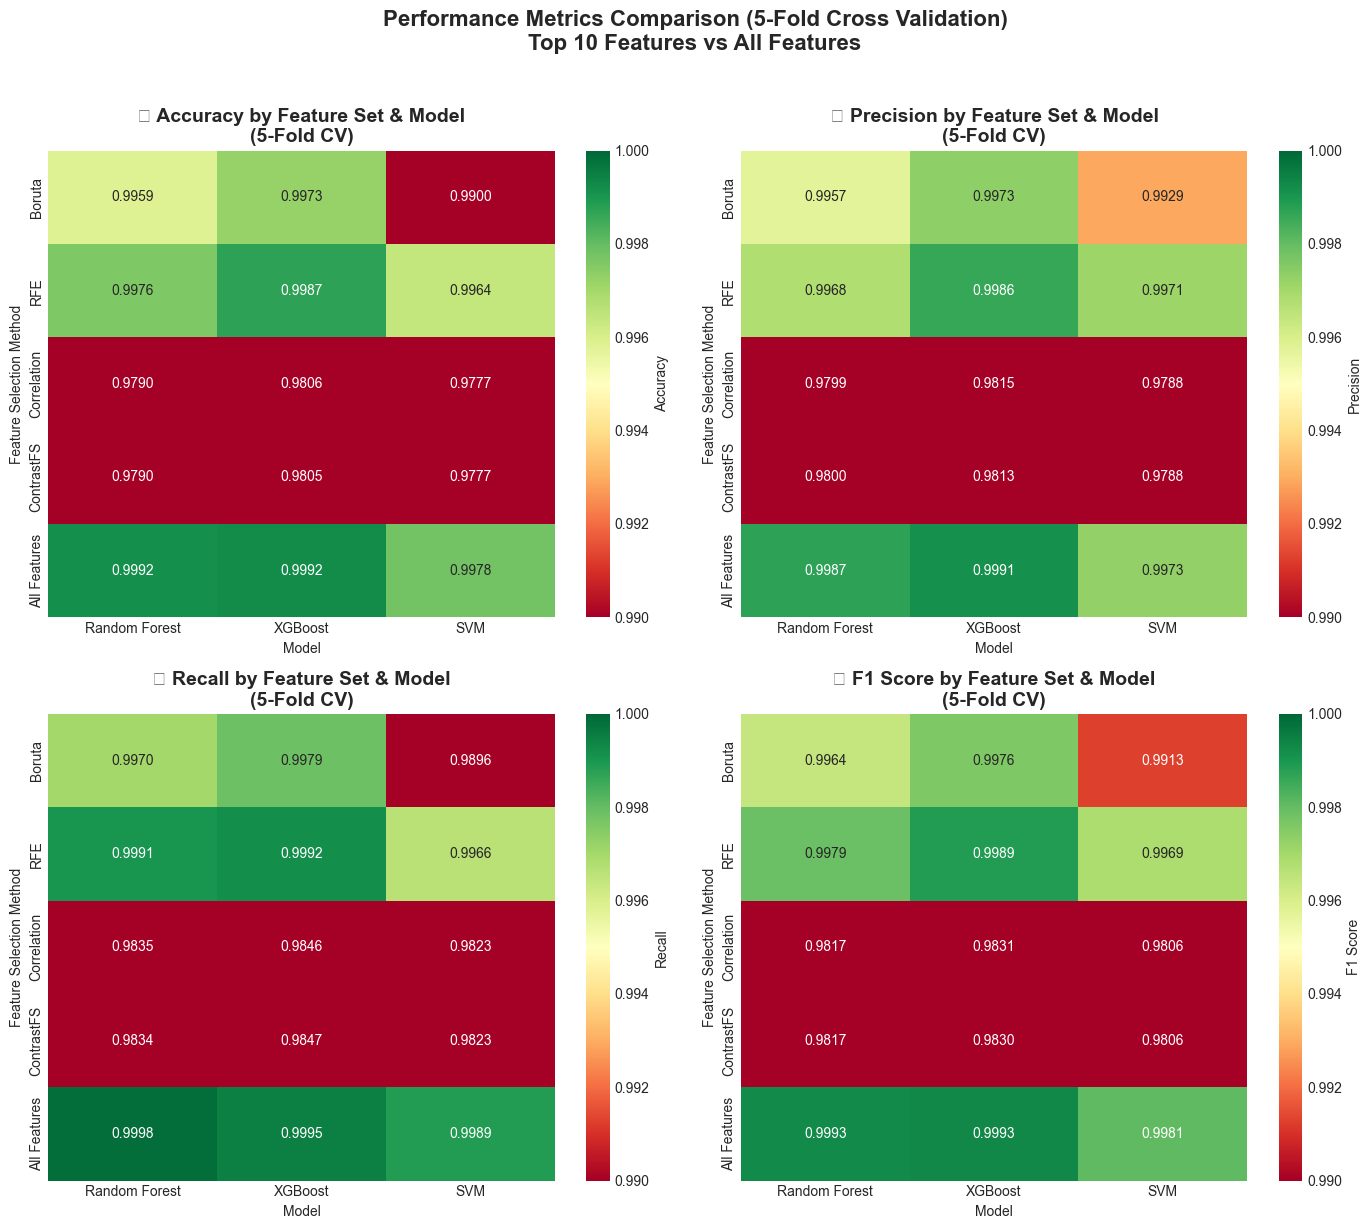


✅ Heatmap saved to TrainingTime_FIXversion/metrics_heatmap.png


In [13]:
# Create output folder if not exists
import os
os.makedirs('TrainingTime_FIXversion', exist_ok=True)

# ============================================================
# 1. HEATMAP - Accuracy Comparison
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Accuracy Heatmap
ax1 = axes[0, 0]
sns.heatmap(accuracy_df, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.99, vmax=1.0, 
            ax=ax1, cbar_kws={'label': 'Accuracy'})
ax1.set_title('🎯 Accuracy by Feature Set & Model\n(5-Fold CV)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Feature Selection Method')

# Precision Heatmap
ax2 = axes[0, 1]
sns.heatmap(precision_df, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.99, vmax=1.0,
            ax=ax2, cbar_kws={'label': 'Precision'})
ax2.set_title('🎯 Precision by Feature Set & Model\n(5-Fold CV)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('Feature Selection Method')

# Recall Heatmap
ax3 = axes[1, 0]
sns.heatmap(recall_df, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.99, vmax=1.0,
            ax=ax3, cbar_kws={'label': 'Recall'})
ax3.set_title('🎯 Recall by Feature Set & Model\n(5-Fold CV)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Model')
ax3.set_ylabel('Feature Selection Method')

# F1 Heatmap
ax4 = axes[1, 1]
sns.heatmap(f1_df, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0.99, vmax=1.0,
            ax=ax4, cbar_kws={'label': 'F1 Score'})
ax4.set_title('🎯 F1 Score by Feature Set & Model\n(5-Fold CV)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Model')
ax4.set_ylabel('Feature Selection Method')

plt.suptitle('Performance Metrics Comparison (5-Fold Cross Validation)\nTop 10 Features vs All Features', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('TrainingTime_FIXversion/metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Heatmap saved to TrainingTime_FIXversion/metrics_heatmap.png")

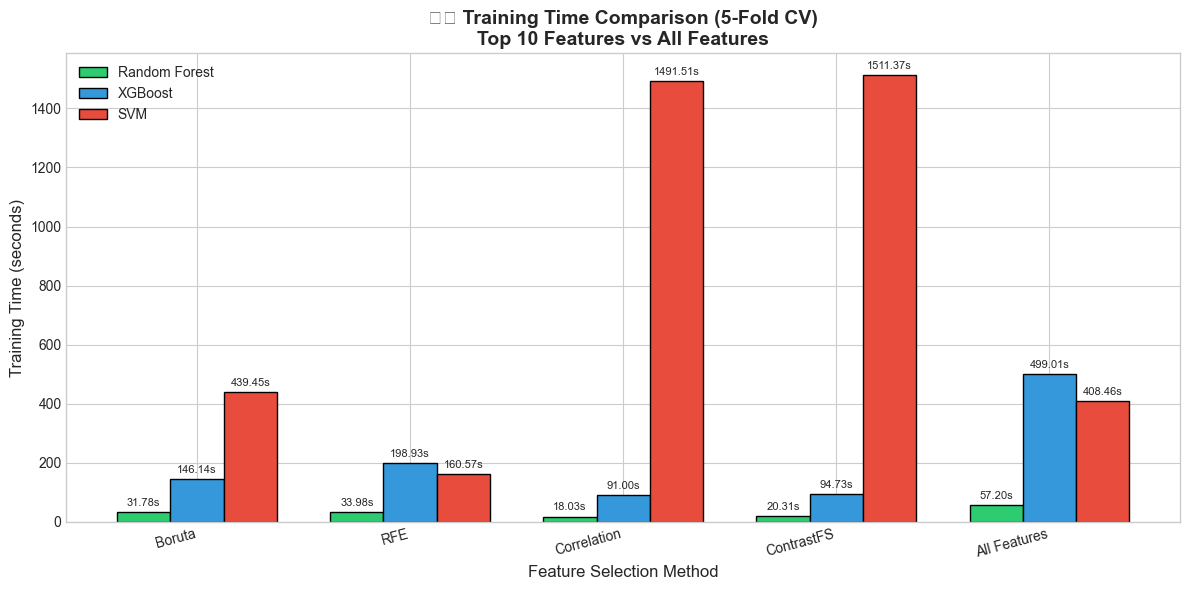


✅ Training Time chart saved to TrainingTime_FIXversion/training_time_comparison.png


In [14]:
# ============================================================
# 2. BAR CHART - Training Time Comparison
# ============================================================
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_order))
width = 0.25

bars1 = ax.bar(x - width, time_df['Random Forest'], width, label='Random Forest', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, time_df['XGBoost'], width, label='XGBoost', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, time_df['SVM'], width, label='SVM', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Feature Selection Method', fontsize=12)
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('⏱️ Training Time Comparison (5-Fold CV)\nTop 10 Features vs All Features', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(feature_order, rotation=15, ha='right')
ax.legend(loc='upper left')

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.savefig('TrainingTime_FIXversion/training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training Time chart saved to TrainingTime_FIXversion/training_time_comparison.png")

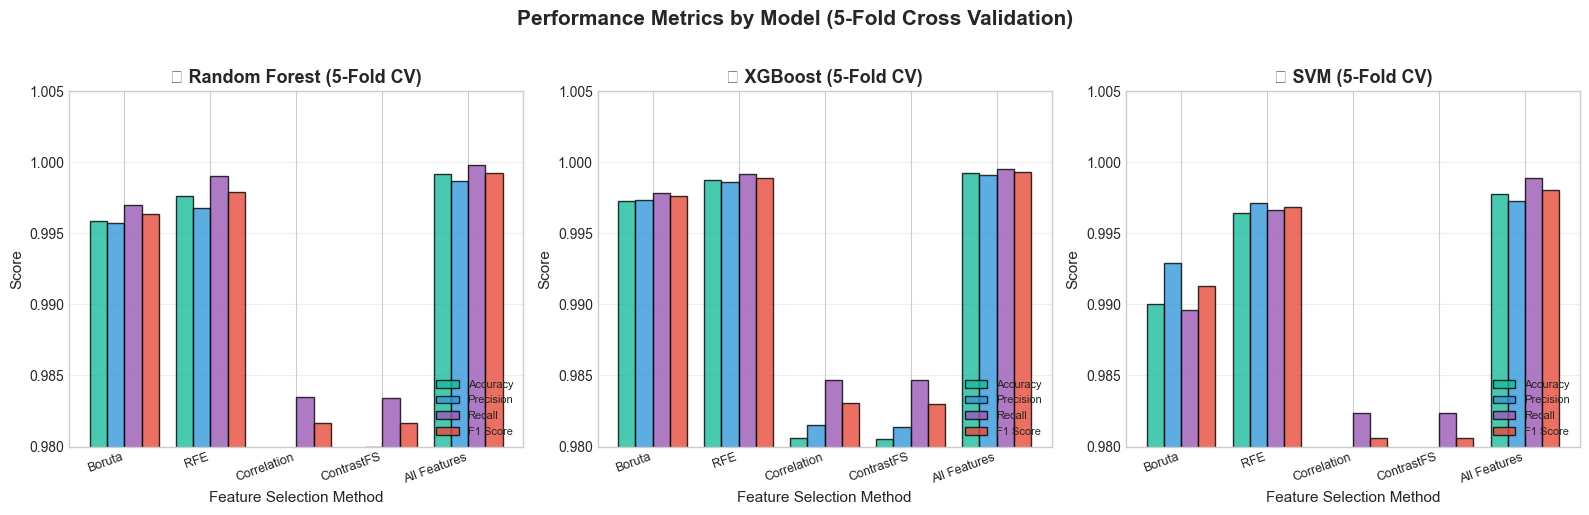


✅ Metrics by Model chart saved to TrainingTime_FIXversion/metrics_by_model.png


In [15]:
# ============================================================
# 3. GROUPED BAR CHART - All Metrics by Model
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_data = {
    'Accuracy': accuracy_df,
    'Precision': precision_df,
    'Recall': recall_df,
    'F1 Score': f1_df
}

colors = ['#1abc9c', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

for idx, model in enumerate(model_order):
    ax = axes[idx]
    
    x = np.arange(len(feature_order))
    width = 0.2
    
    for i, (metric_name, metric_df) in enumerate(metrics_data.items()):
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, metric_df[model], width, label=metric_name, color=colors[i], edgecolor='black', alpha=0.8)
    
    ax.set_xlabel('Feature Selection Method', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'📊 {model} (5-Fold CV)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_order, rotation=20, ha='right', fontsize=9)
    ax.set_ylim(0.98, 1.005)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Performance Metrics by Model (5-Fold Cross Validation)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('TrainingTime_FIXversion/metrics_by_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Metrics by Model chart saved to TrainingTime_FIXversion/metrics_by_model.png")

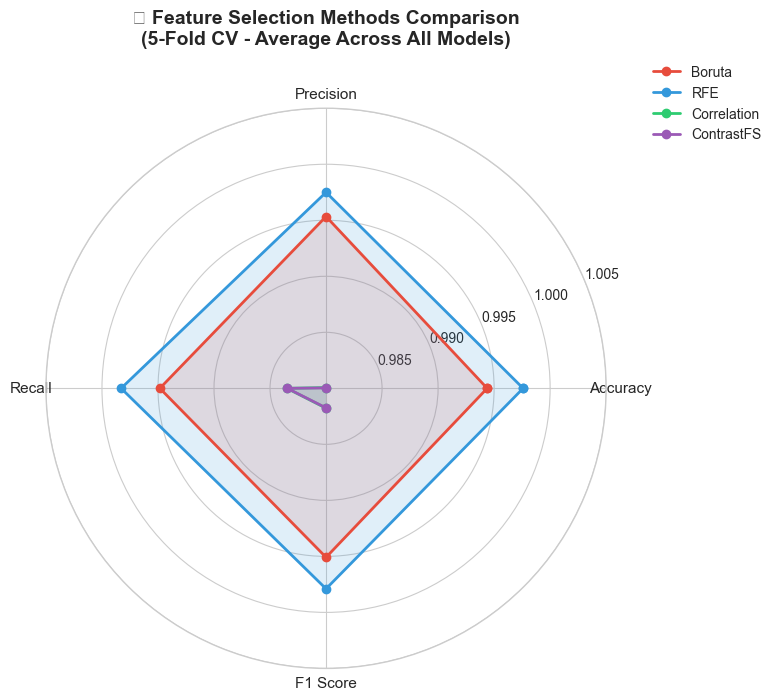


✅ Radar chart saved to TrainingTime_FIXversion/radar_chart.png


In [16]:
# ============================================================
# 4. RADAR CHART - Feature Selection Methods Comparison
# ============================================================
from math import pi

# Prepare data for radar chart - average across models
avg_metrics = pd.DataFrame({
    'Accuracy': accuracy_df.mean(axis=1),
    'Precision': precision_df.mean(axis=1),
    'Recall': recall_df.mean(axis=1),
    'F1 Score': f1_df.mean(axis=1)
})

# Only top 10 features (exclude All Features for cleaner comparison)
top10_methods = ['Boruta', 'RFE', 'Correlation', 'ContrastFS']
avg_metrics_top10 = avg_metrics.loc[top10_methods]

categories = list(avg_metrics_top10.columns)
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors_radar = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for idx, method in enumerate(top10_methods):
    values = avg_metrics_top10.loc[method].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=method, color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0.98, 1.005)
ax.set_title('🎯 Feature Selection Methods Comparison\n(5-Fold CV - Average Across All Models)', 
             fontsize=14, fontweight='bold', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('TrainingTime_FIXversion/radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Radar chart saved to TrainingTime_FIXversion/radar_chart.png")

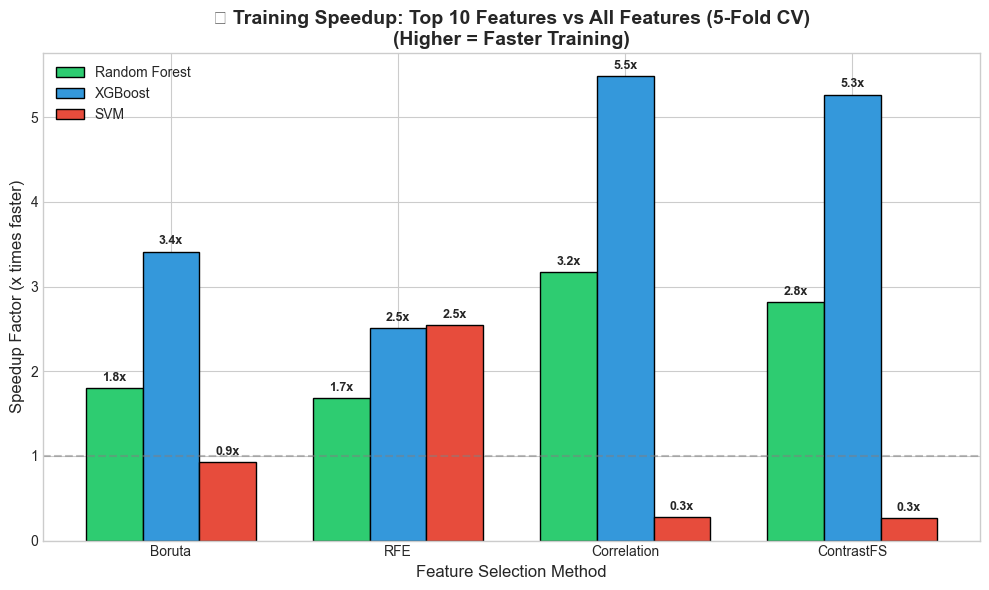


✅ Speedup comparison saved to TrainingTime_FIXversion/speedup_comparison.png


In [17]:
# ============================================================
# 5. TRAINING TIME EFFICIENCY - Speedup vs All Features
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate speedup ratio (All Features time / Top 10 time)
all_features_time = time_df.loc['All Features']
speedup_data = {}

for method in ['Boruta', 'RFE', 'Correlation', 'ContrastFS']:
    speedup_data[method] = all_features_time / time_df.loc[method]

speedup_df = pd.DataFrame(speedup_data).T

x = np.arange(len(speedup_df.index))
width = 0.25

bars1 = ax.bar(x - width, speedup_df['Random Forest'], width, label='Random Forest', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, speedup_df['XGBoost'], width, label='XGBoost', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, speedup_df['SVM'], width, label='SVM', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Feature Selection Method', fontsize=12)
ax.set_ylabel('Speedup Factor (x times faster)', fontsize=12)
ax.set_title('🚀 Training Speedup: Top 10 Features vs All Features (5-Fold CV)\n(Higher = Faster Training)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(speedup_df.index)
ax.legend()
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}x',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('TrainingTime_FIXversion/speedup_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Speedup comparison saved to TrainingTime_FIXversion/speedup_comparison.png")

In [18]:
# ============================================================
# 6. SUMMARY TABLE - Beautiful Styled Table
# ============================================================
print("="*80)
print("📋 FINAL RESULTS SUMMARY (5-Fold Cross Validation)")
print("="*80)

# Create summary table
summary_data = []
for fs in feature_order:
    for model in model_order:
        summary_data.append({
            'Feature Set': fs,
            'Model': model,
            'Accuracy': f"{accuracy_df.loc[fs, model]:.4f}",
            'Precision': f"{precision_df.loc[fs, model]:.4f}",
            'Recall': f"{recall_df.loc[fs, model]:.4f}",
            'F1 Score': f"{f1_df.loc[fs, model]:.4f}",
            'Training Time (s)': f"{time_df.loc[fs, model]:.4f}"
        })

summary_table = pd.DataFrame(summary_data)

# Display with styling
print("\n")
print(summary_table.to_string(index=False))

# Save to CSV
summary_table.to_csv('TrainingTime_FIXversion/complete_summary.csv', index=False)
print("\n✅ Complete summary saved to TrainingTime_FIXversion/complete_summary.csv")

📋 FINAL RESULTS SUMMARY (5-Fold Cross Validation)


 Feature Set         Model Accuracy Precision Recall F1 Score Training Time (s)
      Boruta Random Forest   0.9959    0.9957 0.9970   0.9964           31.7801
      Boruta       XGBoost   0.9973    0.9973 0.9979   0.9976          146.1401
      Boruta           SVM   0.9900    0.9929 0.9896   0.9913          439.4468
         RFE Random Forest   0.9976    0.9968 0.9991   0.9979           33.9802
         RFE       XGBoost   0.9987    0.9986 0.9992   0.9989          198.9324
         RFE           SVM   0.9964    0.9971 0.9966   0.9969          160.5723
 Correlation Random Forest   0.9790    0.9799 0.9835   0.9817           18.0323
 Correlation       XGBoost   0.9806    0.9815 0.9846   0.9831           90.9966
 Correlation           SVM   0.9777    0.9788 0.9823   0.9806         1491.5150
  ContrastFS Random Forest   0.9790    0.9800 0.9834   0.9817           20.3078
  ContrastFS       XGBoost   0.9805    0.9813 0.9847   0.9830       

---
## 7. Export Results to CSV
---

In [19]:
# Create the formatted Results CSV matching the template structure
# Save to TrainingTime_FIXversion/ResultFIXversion.csv

# Prepare data in the exact format required
output_data = []

# Row 1: Title
output_data.append(['Top 10 Feature Set vs All features (5-Fold CV)'] + [''] * 15)

# Row 2: Empty
output_data.append([''] * 16)

# Row 3: Metric headers
output_data.append(['Accuracy', '', '', '', '', '', 'Precision', '', '', '', '', '', 'Training Time (in sec)', '', '', ''])

# Row 4: Empty
output_data.append([''] * 16)

# Row 5: Model headers for Accuracy, Precision, Training Time
output_data.append(['', 'Random Forest', 'XGBoost', 'SVM', '', '', '', 'Random Forest', 'XGBoost', 'SVM', '', '', '', 'Random Forest', 'XGBoost', 'SVM'])

# Rows 6-10: Data rows for Accuracy, Precision, Training Time
for fs in feature_order:
    row = [
        fs,
        f"{accuracy_df.loc[fs, 'Random Forest']:.4f}",
        f"{accuracy_df.loc[fs, 'XGBoost']:.4f}",
        f"{accuracy_df.loc[fs, 'SVM']:.4f}",
        '', '',
        fs,
        f"{precision_df.loc[fs, 'Random Forest']:.4f}",
        f"{precision_df.loc[fs, 'XGBoost']:.4f}",
        f"{precision_df.loc[fs, 'SVM']:.4f}",
        '', '',
        fs,
        f"{time_df.loc[fs, 'Random Forest']:.4f}",
        f"{time_df.loc[fs, 'XGBoost']:.4f}",
        f"{time_df.loc[fs, 'SVM']:.4f}"
    ]
    output_data.append(row)

# Add empty rows
for _ in range(4):
    output_data.append([''] * 16)

# Recall and F1 section
output_data.append(['Recall', '', '', '', '', '', 'F1', '', '', '', '', '', '', '', '', ''])

# Empty row
output_data.append([''] * 16)

# Model headers for Recall, F1
output_data.append(['', 'Random Forest', 'XGBoost', 'SVM', '', '', '', 'Random Forest', 'XGBoost', 'SVM', '', '', '', '', '', ''])

# Data rows for Recall, F1
for fs in feature_order:
    row = [
        fs,
        f"{recall_df.loc[fs, 'Random Forest']:.4f}",
        f"{recall_df.loc[fs, 'XGBoost']:.4f}",
        f"{recall_df.loc[fs, 'SVM']:.4f}",
        '', '',
        fs,
        f"{f1_df.loc[fs, 'Random Forest']:.4f}",
        f"{f1_df.loc[fs, 'XGBoost']:.4f}",
        f"{f1_df.loc[fs, 'SVM']:.4f}",
        '', '', '', '', '', ''
    ]
    output_data.append(row)

# Create DataFrame and save to NEW FILE: ResultFIXversion.csv
output_df = pd.DataFrame(output_data)
output_df.to_csv('TrainingTime_FIXversion/ResultFIXversion.csv', index=False, header=False)

print("✅ Results exported to TrainingTime_FIXversion/ResultFIXversion.csv!")

✅ Results exported to TrainingTime_FIXversion/ResultFIXversion.csv!


In [20]:
# Save the selected features summary for reference
features_summary = {
    'Feature_Selection_Method': ['Boruta', 'RFE', 'Correlation', 'ContrastFS'],
    'Features': [
        ', '.join(boruta_top10),
        ', '.join(rfe_top10),
        ', '.join(correlation_top10),
        ', '.join(contrast_top10)
    ]
}
features_summary_df = pd.DataFrame(features_summary)
features_summary_df.to_csv('TrainingTime_FIXversion/selected_features_summary.csv', index=False)
print("✅ Features summary saved to TrainingTime_FIXversion/selected_features_summary.csv!")
print(features_summary_df)

✅ Features summary saved to TrainingTime_FIXversion/selected_features_summary.csv!
  Feature_Selection_Method                                           Features
0                   Boruta  LineOfCode, NoOfExternalRef, NoOfSelfRef, NoOf...
1                      RFE  LineOfCode, LargestLineLength, NoOfExternalRef...
2              Correlation  HasSocialNet, HasCopyrightInfo, HasDescription...
3               ContrastFS  HasSocialNet, HasCopyrightInfo, HasDescription...


---
## 8. Final Summary
---

In [21]:
print("="*60)
print("🎉 EXPERIMENT COMPLETED SUCCESSFULLY! (5-Fold Cross Validation)")
print("="*60)
print("\n📁 Output Files in TrainingTime_FIXversion/:")
print("   • ResultFIXversion.csv - Main results in template format")
print("   • complete_summary.csv - Detailed results")
print("   • selected_features_summary.csv - Top 10 features per method")
print("   • Various visualizations (PNG files)")
print("\n📊 Experiment Summary:")
print(f"   • Dataset: {len(df)} samples")
print(f"   • Models tested: Random Forest, XGBoost (GradientBoosting), SVM")
print(f"   • Feature sets: Boruta, RFE, Correlation, ContrastFS + All Features")
print(f"   • Validation: 5-Fold Stratified Cross Validation")
print(f"   • Total experiments: {len(feature_sets) * len(model_order)} (5 feature sets × 3 models)")
print("="*60)

🎉 EXPERIMENT COMPLETED SUCCESSFULLY! (5-Fold Cross Validation)

📁 Output Files in TrainingTime_FIXversion/:
   • ResultFIXversion.csv - Main results in template format
   • complete_summary.csv - Detailed results
   • selected_features_summary.csv - Top 10 features per method
   • Various visualizations (PNG files)

📊 Experiment Summary:
   • Dataset: 235795 samples
   • Models tested: Random Forest, XGBoost (GradientBoosting), SVM
   • Feature sets: Boruta, RFE, Correlation, ContrastFS + All Features
   • Validation: 5-Fold Stratified Cross Validation
   • Total experiments: 15 (5 feature sets × 3 models)
